# NHL Vegas Golden Knights - Retention Redshift Insert
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Mar 7, 2022

In [ ]:
import boto3
import getpass
import pyodbc
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from pytz import timezone
from pycaret.classification import *

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [ ]:
# connect to SQL Server.
SERVER = '52.44.171.130' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password ····················


In [ ]:
lkupclientid = 33 # vegas golden knights
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrVGK].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38984 entries, 0 to 38983
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   lkupClientId            38984 non-null  int64  
 1   dimCustomerMasterId     38984 non-null  int64  
 2   customerNumber          38984 non-null  object 
 3   year                    38984 non-null  int64  
 4   productGrouping         38984 non-null  object 
 5   totalSpent              38984 non-null  float64
 6   recentDate              38984 non-null  object 
 7   attendancePercent       38984 non-null  float64
 8   renewedBeforeDays       38983 non-null  float64
 9   isBuyer                 38984 non-null  object 
 10  source_tenure           38984 non-null  int64  
 11  tenure                  38983 non-null  float64
 12  distToVenue             38984 non-null  float64
 13  totalGames              38984 non-null  int64  
 14  recency                 38984 non-null

### We should specify the features used in our model:

In [ ]:
# choose the features for the stellar base retention model
features = [
    "dimCustomerMasterId",
    "attendancePercent",
    "distToVenue",
    "isNextYear_Buyer",
    "lkupClientId",
    "productGrouping",
    "recency",
    "recentDate",
    "source_tenure",
    "totalSpent",
    "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (28573, 19)
Unseen Data For Predictions: (5042, 19)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [ ]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=[
        "dimCustomerMasterId",
        "lkupClientId",
        "productGrouping",
        "recentDate",
        "year"
    ],
    silent=True,
    verbose=False,
    numeric_features=[
        "attendancePercent",
        "distToVenue",
        "recency",
        "source_tenure",
        "totalSpent"
    ]
);

### The evaluation output prints a score grid that shows average Accuracy, AUC, Recall, Precision, F1 and Kappa accross the folds (10 by default) along with training time:

In [ ]:
model_matrix = compare_models(
    fold= 10,
    include= ["gbc","lightgbm","lr","xgboost"],
    n_select= 4,
    probability_threshold= 0.75
)
results = pull()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8859,0.9321,0.9083,0.9263,0.9172,0.7340,0.7344,0.5400
lightgbm,Light Gradient Boosting Machine,0.8848,0.9351,0.9033,0.9290,0.9160,0.7327,0.7335,0.1690
gbc,Gradient Boosting Classifier,0.8648,0.9307,0.8714,0.9299,0.8996,0.6933,0.6969,0.5090
lr,Logistic Regression,0.6671,0.7694,0.5900,0.8961,0.7114,0.3555,0.4005,0.1630


In [ ]:
models = []
for idx, m in enumerate(model_matrix):
    
    model = create_model(m)
    final_model = finalize_model(model)
    
    models.append({
        "name": str(results.iloc[idx]["Model"]),
        "model": final_model
    })

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6735,0.7570,0.6069,0.8882,0.7211,0.3595,0.3987
1,0.6628,0.7817,0.5796,0.8998,0.7051,0.3520,0.4002
2,0.6657,0.7597,0.5944,0.8877,0.7121,0.3489,0.3901
3,0.6776,0.7643,0.6098,0.8925,0.7246,0.3676,0.4076
4,0.6579,0.7709,0.5779,0.8921,0.7014,0.3413,0.3871
5,0.6608,0.7637,0.5814,0.8935,0.7044,0.3458,0.3914
6,0.6706,0.7600,0.6059,0.8843,0.7191,0.3531,0.3911
7,0.6738,0.7896,0.5891,0.9103,0.7153,0.3721,0.4222
8,0.6680,0.7804,0.5773,0.9138,0.7075,0.3661,0.4198
9,0.6606,0.7669,0.5773,0.8986,0.7030,0.3483,0.3965


### Let's load in our 2021 season data and get retention scores using the model:

In [ ]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference = df_inference[features]

df_inference.shape

(5369, 19)

In [ ]:
predictions = []
for idx, final_m in enumerate(models):
    
    df_predictions = (predict_model(final_m['model'], data=df_inference, raw_score=True))
    df_predictions = df_predictions[df_predictions["Score_1"] >= 0.025]
    final_m["predictions"] = df_predictions

ValueError: Number of features of the model must match the input. Model n_features_ is 29 and input n_features is 13 

### We can create some histograms to visualize each model distribution:

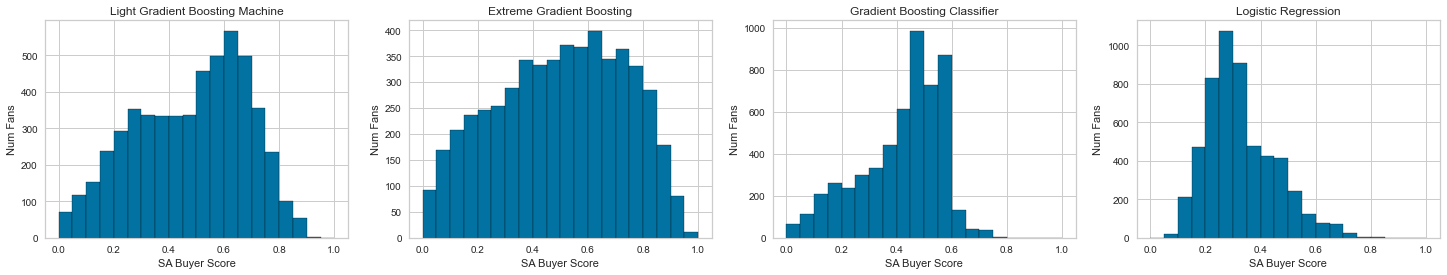

In [ ]:
for idx, model in enumerate(models):
    
    plt.subplot(1, 4, idx+1)
    plt.title(model["name"])
    plt.ylabel("Num Fans")
    plt.xlabel("SA Buyer Score")
    plt.hist(model["predictions"]["Score_1"], bins=20, edgecolor="black", range=(0,1))
                            
plt.rcParams["figure.figsize"] = (25,4)
plt.show()

### We can also see how many purchases there are in each range of scores:

In [ ]:
df_new = pd.DataFrame()

for idx, model in enumerate(models):
    df_new["Score"] = df_new.index
    df_new[str(models[idx]["name"])] = models[idx]["predictions"]["Score_1"].value_counts(bins=np.arange(0, 1.05, 0.05)).sort_index(ascending=False)

df_new.reset_index(inplace=True, drop=True)
df_new

,Score,Extreme Gradient Boosting,Light Gradient Boosting Machine,Gradient Boosting Classifier,Logistic Regression
0,"(0.95, 1.0]",104,1,0,1
1,"(0.9, 0.95]",340,36,0,1
2,"(0.85, 0.9]",447,161,101,3
3,"(0.8, 0.85]",440,327,178,1
4,"(0.75, 0.8]",415,438,483,2
5,"(0.7, 0.75]",386,493,636,10
6,"(0.65, 0.7]",364,502,636,69
7,"(0.6, 0.65]",310,486,636,194
8,"(0.55, 0.6]",277,481,546,336
9,"(0.5, 0.55]",239,396,363,137


### Select the model you would like to use for updating scores:

In [ ]:
selected_model = "Extreme Gradient Boosting"

for model in models:
    if model["name"] == selected_model:

        df_scores = model["predictions"]
                                 
df_scores.info()

TypeError: 'function' object is not iterable

### Now we can push these scores into RedShift so that we can see what the new scoring looks like in the CDP:

In [ ]:
import awswrangler as wr
import boto3
import pandas as pd

boto3.setup_default_session(profile_name='Stellaralgo-DataScienceAdmin')
    
# Create new connection to RedShift API
con_redshift = wr.data_api.redshift.connect(
    cluster_id="qa-app",
    database="stlrvgk",
    db_user="admin"
)

df = wr.data_api.redshift.read_sql_query(
    #sql = """
    #    copy stlrvgk.dw.customerretentionscores 
    #    from 's3://explore-model-retention-us-east-1-ai-oprj0o/ai/data-sci-retention/inference/NHL-VGK/9ae093ef/output/inference_data.csv.out' 
    #    iam_role 'arn:aws:iam::173696899631:role/redshift-etl-role';
    #""",
    sql="SELECT * FROM stlrvgk.dw.customerretentionscores",
    con=con_redshift
) 

df.head()

In [ ]:
! aws sso login --profile Stellaralgo-DataScienceAdmin

Attempting to automatically open the SSO authorization page in your default browser.
If the browser does not open or you wish to use a different device to authorize this request, open the following URL:

https://device.sso.us-east-1.amazonaws.com/

Then enter the code:

VFDT-RFML
Successully logged into Start URL: https://stellaralgo.awsapps.com/start


In [ ]:
# Create a new session and connect to RedShift
try:
    session = boto3.session.Session(profile_name='Stellaralgo-DataScienceAdmin')
    client = session.client('redshift')

    cluster_creds = client.get_cluster_credentials(
        DbUser='StellarDataScienceAdmin',
        DbName='stlrvgk',
        DbGroups=['admin_group'],
        ClusterIdentifier='qa-app',
        AutoCreate=True
    )
    print("CLUSTER CREDENTIALS RETRIEVED")

except Exception as err:
    print('FAILED TO RETRIEVE CLUSTER CREDS!', err)

CLUSTER CREDENTIALS RETRIEVED


### Insert the new scores into the customerRetentionScores table:

In [ ]:
try:
    # Create connection to RedShift
    conn = psycopg2.connect(
        host='qa-app.ctjussvyafp4.us-east-1.redshift.amazonaws.com',
        port=5439,
        user=cluster_creds['DbUser'],
        password=cluster_creds['DbPassword'],
        database='stlrvgk'
    )
    print('CREATED CONNECTION TO DATABASE')
    
    cursor = conn.cursor()
    
    fields = f"""
    INSERT INTO dw.customerretentionscores (
        attendancePercentage,
        currversnflag,
        dimcustomermasterid,
        insertdate,
        lkupclientid,
        mostrecentattendance,
        product,
        sascore,
        seasonYear,
        tenuredays
    ) VALUES """

    # Insert Dataframe into SQL Server:
    values_list = []
    for i, (index, row) in enumerate(df_scores.iterrows()):
        
        values = f"""
            (
                {str(row.attendancePercent)},
                {str(0)},
                {str(row.dimCustomerMasterId)},
                '{str(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))}',
                {str(lkupclientid)},
                '{str(row.recentDate)}',
                '{str(row.productGrouping)}',
                {str(round(row.Score_1,4))},
                {str(row.year)},
                {str(row.source_tenure)}
            )"""
                        
        values_list.append(values)
    
        if((i+1)%100 == 0):
            print(f" > BATCHED ROWS: {i+1}-{i+10} | {round(100*(i+1)/len(df_scores),0)}% COMPLETED")
    
    insert_statement = fields + ",".join(values_list)+";"
    
    cursor.execute(insert_statement)
    conn.commit()
        
    print("RETENTION SCORE INSERTS COMPLETED")

except Exception as err:
    cursor.execute("rollback")
    print("ERROR WHILE INSERTING RETENTION SCORES TO DATABASE:", err)

finally:
    if conn:
        #cursor.close()
        #conn.close()
        print("REDSHIFT CONNECTION HAS BEEN CLOSED")

CREATED CONNECTION TO DATABASE
ERROR WHILE INSERTING RETENTION SCORES TO DATABASE: 'Series' object has no attribute 'recentDate'
REDSHIFT CONNECTION HAS BEEN CLOSED


### Let's query RedShift to make sure our records go into the database:

In [ ]:
try:
    # Create connection to RedShift
    conn = psycopg2.connect(
        host='qa-app.ctjussvyafp4.us-east-1.redshift.amazonaws.com',
        port=5439,
        user=cluster_creds['DbUser'],
        password=cluster_creds['DbPassword'],
        database='stlrvgk'
    )
    print('CREATED CONNECTION TO DATABASE')
    
    cursor = conn.cursor()
    
    cursor.execute("SELECT * FROM dw.customerretentionscores;")
    records = cursor.fetchall()
    print(records)

except Exception as err:
    cursor.execute("rollback")
    print("ERROR SELECTING RETENTION SCORES FROM DATABASE:", err)
    
finally:
    if conn:
        #cursor.close()
        print("REDSHIFT CONNECTION HAS BEEN CLOSED")

### Delete records from DB (for testing):

In [72]:
try:
    delete_query = """DELETE FROM dw.customerretentionscores where currversnflag = false"""
    cursor.execute(delete_query)
    conn.commit()

    count = cursor.rowcount
    print(count, "RECORDS DELETED SUCCESSFULLY")

    # Fetch result
    cursor.execute("SELECT * FROM dw.customerretentionscores")
    print("Result ", cursor.fetchall())
    
    print("RETENTION SCORES DELETED FROM DATABASE")
    
except Exception as err:
    cursor.execute("rollback")
    print("ERROR DELETING RETENTION SCORES TO DATABASE:", err)

4266 RECORDS DELETED SUCCESSFULLY
Result  []
RETENTION SCORES DELETED FROM DATABASE


In [ ]:
cursor = connection.cursor()

# Executing a SQL query to insert data into  table
insert_query = """ INSERT INTO mobile (ID, MODEL, PRICE) VALUES (1, 'Iphone12', 1100)"""
cursor.execute(insert_query)
connection.commit()
print("1 Record inserted successfully")

# Fetch result
cursor.execute("SELECT * from mobile")
record = cursor.fetchall()
print("Result ", record)

In [ ]:
# get IAM role from AWS


# connect to RedShift Server
conn = psycopg2.connect(
    dbname = 'datascience',
    host = 'qa-app.ctjussvyafp4.us-east-1.redshift.amazonaws.com:5439/dev',
    port = 5439,
    user = 'dsAdmin',
    #password=getpass.getpass(prompt='Enter your password'),
    sslmode='require'
)

In [ ]:
# connect to SQL Server
cnxn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)
cursor = cnxn.cursor()

date_time_now = datetime.now().strftime("%m-%d-%Y %H:%M:%S")

try:
    # Insert Dataframe into SQL Server:
    for index, row in df_scores.iterrows():
        
        fields = f"""
            INSERT INTO ds.customerScores (
                dimCustomerMasterId,
                buyer_score,
                tenuredays,
                attendancePercentage,
                mostrecentattendance,
                year,
                lkupclientid,
                productgrouping,
                seasonYear,
                insertDate
            )
        """
        
        values = f"""
            VALUES(
                {str(row.dimCustomerMasterId)},
                {str(round(row.Score_1,4))},
                {str(row.source_tenure)},
                {str(row.attendancePercent)},
                '{str(row.recentDate)}',
                {str(row.year)},
                {str(lkupclientid)},
                '{str(row.productGrouping)}',
                {str(row.year)},
                '{str(date_time_now)}'
            )"""
        
        insert_statement = fields + values
        
        cursor.execute(insert_statement)
        cnxn.commit()

except Exception as err:
    print("ERROR INSERTING RETENTION SCORES TO DATABASE:", err)
        
cursor.close()
print("RETENTION SCORES WRITTEN TO DATABASE")